In [10]:
import warnings

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,concatenate,LSTM,SimpleRNN,Dropout,Embedding
from keras.layers.normalization import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from kaggle_datasets import KaggleDatasets
import transformers
import traitlets
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import train_test_split

warnings.simplefilter("ignore")

In [21]:
train = pd.read_csv('../input/quora-record-linkage/quora_train.csv',index_col=0,usecols=[1,2,3,4,5,6]).dropna()
test_data = pd.read_csv('../input/quora-record-linkage/quora_test.csv',index_col=0,usecols=[1,2,3,4,5,6]).dropna()

In [12]:
seed = 7
np.random.seed(seed)
X = train.iloc[:,2:4]
Y = train.iloc[:,4]
train_data, val_data, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=seed)
X_test = test.iloc[:,2:4]
y_test = test.iloc[:,4]

In [13]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [14]:
NUM_WORDS=30522
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(train_data.question1+' '+train_data.question2)
sequences1_train = tokenizer.texts_to_sequences(train_data.question1)
sequences2_train = tokenizer.texts_to_sequences(train_data.question2)
sequences1_valid=tokenizer.texts_to_sequences(val_data.question1)
sequences2_valid=tokenizer.texts_to_sequences(val_data.question2)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 72738 unique tokens.


In [15]:
X1_train = pad_sequences(sequences1_train,maxlen=32)
X2_train = pad_sequences(sequences2_train,maxlen=32)
X1_val = pad_sequences(sequences1_valid,maxlen=32)
X2_val = pad_sequences(sequences2_valid,maxlen=32)
print('Shape of X train and X validation tensor:', X1_train.shape,X1_val.shape)
print('Shape of label train and validation tensor:', y_train.shape,y_val.shape)

Shape of X train and X validation tensor: (258782, 32) (64696, 32)
Shape of label train and validation tensor: (258782,) (64696,)


In [16]:
def build_lstm_model(MAX_SEQUENCE_LENGTH=32):
    

    embedding_layer=Embedding(input_dim=30522,output_dim=64,input_length=MAX_SEQUENCE_LENGTH)
    lstm_layer = LSTM(256, dropout=0.1, recurrent_dropout=0.1)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer(embedded_sequences_2)

    merged = concatenate([x1, y1])
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    merged = Dense(128, activation='relu')(merged)
    merged = Dropout(0.1)(merged)
    merged = BatchNormalization()(merged)

    preds = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [26]:
def build_lstm_base_model(MAX_SEQUENCE_LENGTH=32):
    

    embedding_layer=Embedding(input_dim=30522,output_dim=64,input_length=MAX_SEQUENCE_LENGTH)
    lstm_layer = LSTM(256, dropout=0.1, recurrent_dropout=0.1)

    sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_1 = embedding_layer(sequence_1_input)
    x1 = lstm_layer(embedded_sequences_1)

    sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedded_sequences_2 = embedding_layer(sequence_2_input)
    y1 = lstm_layer(embedded_sequences_2)

    merged = concatenate([x1, y1])

    preds = Dense(1, activation='sigmoid')(merged)
    
    model = Model(inputs=[sequence_1_input, sequence_2_input],outputs=preds)
    adam = Adam(lr=1e-3)
    model.compile(loss='binary_crossentropy',
        optimizer=adam,
        metrics=[tf.keras.metrics.AUC()])
    return model

In [27]:
model=build_lstm_base_model()
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 64)       1953408     input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 256)          328704      embedding_1[0][0]     

In [28]:
model.fit([X1_train,X2_train], y_train, batch_size=1000, epochs=5, verbose=1, validation_data=([X1_val,X2_val],y_val))

Epoch 1/5
259/259 [==============================] - 79s 307ms/step - loss: 0.5437 - auc_1: 0.7679 - val_loss: 0.5052 - val_auc_1: 0.8097
Epoch 2/5
259/259 [==============================] - 80s 309ms/step - loss: 0.4774 - auc_1: 0.8344 - val_loss: 0.4962 - val_auc_1: 0.8200
Epoch 3/5
259/259 [==============================] - 79s 306ms/step - loss: 0.4424 - auc_1: 0.8613 - val_loss: 0.5023 - val_auc_1: 0.8229
Epoch 4/5
259/259 [==============================] - 80s 309ms/step - loss: 0.4066 - auc_1: 0.8847 - val_loss: 0.5099 - val_auc_1: 0.8210
Epoch 5/5
259/259 [==============================] - 80s 308ms/step - loss: 0.3751 - auc_1: 0.9027 - val_loss: 0.5436 - val_auc_1: 0.8241


In [20]:
model.save_weights('lstm.h5')

In [22]:
sequences1_test=tokenizer.texts_to_sequences(test_data.question1)
sequences2_test=tokenizer.texts_to_sequences(test_data.question2.astype(str))
X1_test = pad_sequences(sequences1_test,maxlen=X1_train.shape[1])
X2_test = pad_sequences(sequences2_test,maxlen=X1_train.shape[1])
y_score=model.predict([X1_test,X2_test])

In [23]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt

In [24]:
y_test=test_data.is_duplicate.values
model.evaluate([X1_test,X2_test],y_test)

2528/2528 [==============================] - 74s 29ms/step - loss: 0.5813 - auc: 0.8849


[0.5812848806381226, 0.8849143981933594]

Text(0.5, 1.0, 'Precision-Recall curve: AP=0.82')

<Figure size 432x288 with 0 Axes>

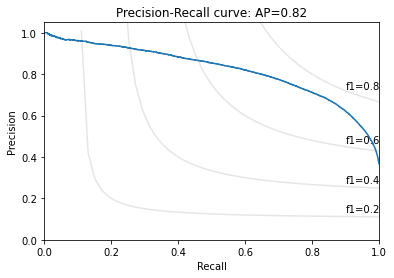

In [25]:
precision, recall, f1=precision_recall_curve(y_test,y_score)
average_precision = average_precision_score(y_test, y_score,average="micro")

plt.clf()
plt.figure()
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
plt.step(recall,precision,where='post')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Precision-Recall curve: AP={0:0.2f}'
    .format(average_precision))